In [1]:
import numpy as np
import lightgbm as lgb

all_data = np.load("all_data_day.npy")

In [2]:
def make_LGBM_dataset(data, old_data_length):
    train_x = []
    train_y = []
    num = 0
    for i in range(len(data) - old_data_length - 1):
        num = num + 1
        x = data[i:i + old_data_length, :]
        y = data[i + old_data_length, 3] - data[i + old_data_length, 0]  # 后一天的收盘价减开盘价
        train_x.append(x)
        train_y.append(y)
    train_x = np.array(train_x).reshape(len(train_x), -1)
    train_y = np.array(train_y).reshape(-1)
    label_y = train_y
    # label_y[label_y <= 0] = 0
    # label_y[label_y > 0] = 1  # 收益大于50才买
    
    return train_x, train_y, label_y

In [3]:
old_data_length = 10  # 使用多少天的历史数据
X, _, Y = make_LGBM_dataset(all_data, old_data_length)

num = len(X)
num_train = int(0.8 * len(X))
X_train = X[:num_train]
Y_train = Y[:num_train]
X_test = X[num_train:]
Y_test = Y[num_train:]

In [4]:
model_name = 'lgbm.model'

train_data = lgb.Dataset(X_train, label=Y_train)
validation_data = lgb.Dataset(X_test, label=Y_test)

# 超参数
params = {'num_leaves': 60, #结果对最终效果影响较大，越大值越好，太大会出现过拟合
          'min_data_in_leaf': 10,
          'objective': 'binary', #定义的目标函数
          'max_depth': -1,
          'learning_rate': 0.001,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 1.0,	#提取的特征比率
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,				#l1正则
          'lambda_l2': 0.1,		#l2正则
          "verbosity": -1,
          "nthread": -1,				#线程数量，-1表示全部线程，线程越多，运行的速度越快
          'metric': {'auc'},	##评价函数选择
          "random_state": 2019,	#随机数种子，可以防止每次运行的结果不一致
          }

# 模型训练
gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data])

# 模型保存
gbm.save_model(model_name)

[1]	training's auc: 0.712487	valid_1's auc: 0.488838
[2]	training's auc: 0.76241	valid_1's auc: 0.484801
[3]	training's auc: 0.798583	valid_1's auc: 0.478108
[4]	training's auc: 0.813464	valid_1's auc: 0.477641
[5]	training's auc: 0.828995	valid_1's auc: 0.475363
[6]	training's auc: 0.839238	valid_1's auc: 0.477679
[7]	training's auc: 0.846739	valid_1's auc: 0.475944
[8]	training's auc: 0.848587	valid_1's auc: 0.477194
[9]	training's auc: 0.856467	valid_1's auc: 0.475803
[10]	training's auc: 0.86227	valid_1's auc: 0.479359
[11]	training's auc: 0.867516	valid_1's auc: 0.47883
[12]	training's auc: 0.869131	valid_1's auc: 0.48152
[13]	training's auc: 0.872277	valid_1's auc: 0.491562
[14]	training's auc: 0.874825	valid_1's auc: 0.495475
[15]	training's auc: 0.876001	valid_1's auc: 0.494637
[16]	training's auc: 0.877458	valid_1's auc: 0.48868
[17]	training's auc: 0.878851	valid_1's auc: 0.487587
[18]	training's auc: 0.880911	valid_1's auc: 0.490885
[19]	training's auc: 0.88298	valid_1's auc

train error:  35.310802398309015
test error:  39.56960943633439


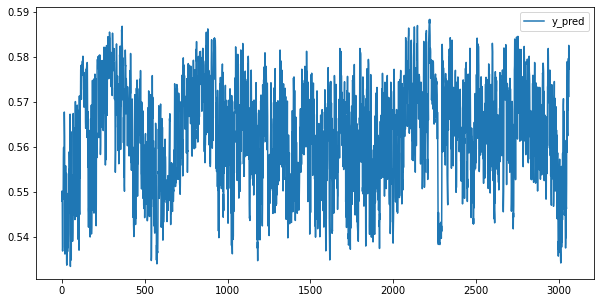

In [7]:
import matplotlib.pyplot as plt

# 模型加载
model_name = 'lgbm.model'
model = lgb.Booster(model_file=model_name)

# 模型预测
y_pre = model.predict(X_train)
train_error = np.mean(abs(Y_train.reshape(-1) - y_pre))
print('train error: ', train_error)

y_pre_2 = model.predict(X_test)
test_error = np.mean(abs(Y_test.reshape(-1) - y_pre_2))
print('test error: ', test_error)

plt.figure(figsize=(10,5))
plt.plot(y_pre, label='y_pred')
# plt.plot(Y_train, label='y')
plt.legend()
plt.show()

In [ ]:
# 问题：准确率太低，过拟合；
# 后续，用研报策略对比